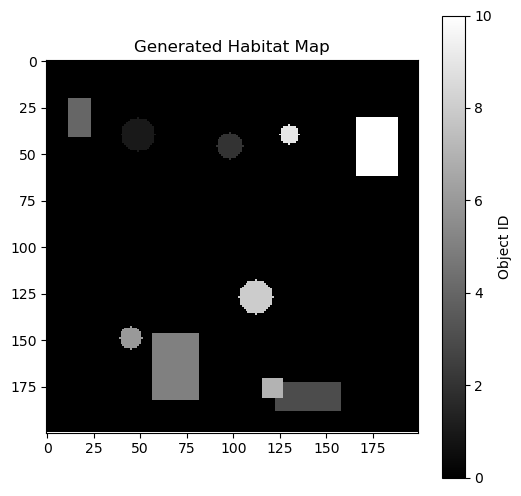

In [57]:
import numpy as np
import matplotlib.pyplot as plt

def generate_habitat_map(map_size=(200,200), num_objects=10, seed=None):
    if seed is not None:
        np.random.seed(seed)

    habitat_map = np.zeros(map_size, dtype=np.uint8)  # Grayscale map (0: empty space)

    for object_id in range(1, num_objects + 1):
        shape = np.random.choice(['rectangle', 'circle'])

        if shape == 'rectangle':
            w, h = np.random.randint(10, 50), np.random.randint(10, 50)  # Random width and height
            x, y = np.random.randint(0, map_size[1] - w), np.random.randint(0, map_size[0] - h)  # Random position
            habitat_map[y:y+h, x:x+w] = object_id

        elif shape == 'circle':
            r = np.random.randint(3, 10)  # Random radius
            cx, cy = np.random.randint(r, map_size[1] - r), np.random.randint(r, map_size[0] - r)  # Random center

            for i in range(map_size[1]):
                for j in range(map_size[0]):
                    if (i - cy) ** 2 + (j - cx) ** 2 <= r ** 2:
                        habitat_map[i, j] = object_id

    return habitat_map

# Generate the map
seed = 23
habitat_map = generate_habitat_map(seed=seed)

# Save the map as a .npy file
np.save("habitat_map.npy", habitat_map)

# Display the map
plt.figure(figsize=(6, 6))
plt.imshow(habitat_map, cmap='gray', interpolation='nearest')
plt.colorbar(label="Object ID")
plt.title("Generated Habitat Map")
plt.show()


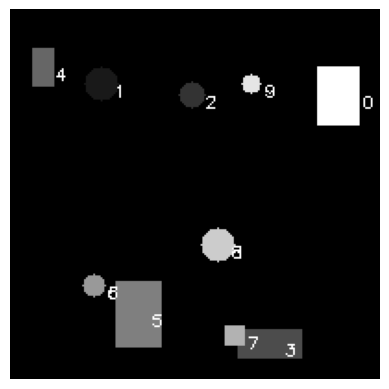

In [56]:
seed = 23
habitat_map = generate_habitat_map(seed=seed)
habitat_map_image = np.zeros((habitat_map.shape[0], habitat_map.shape[1], 3), dtype=np.uint8)  # RGB image


for object_id in range(1, 11):
    # Find the coordinates of the object
    indices = np.where(habitat_map == object_id)
    if indices[0].size > 0:  
    
        habitat_map_image[habitat_map == object_id] = [object_id * 25.5, object_id * 25.5, object_id * 25.5]

        # Calculate the centroid of the object
        y_center, x_center = np.mean(indices, axis=1).astype(int)+ 7

        # Place the object ID label on the map at the centroid
        label = str(object_id)
        cv2.putText(habitat_map_image, label, (x_center, y_center), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 255, 255), 1)

# Display the habitat map with objects and labels using matplotlib
plt.imshow(habitat_map_image)
plt.axis('off')  # Hide axis
plt.show()



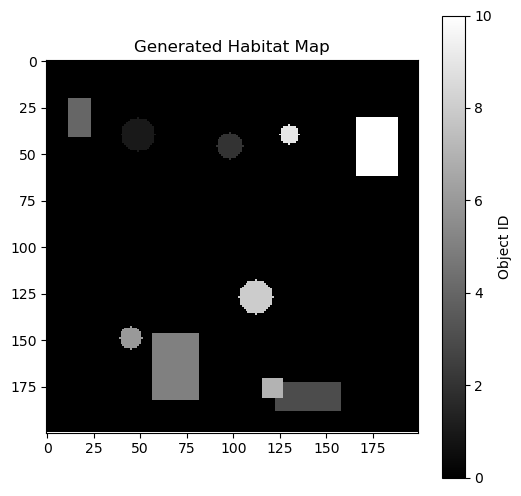

In [32]:
instance_map = np.load("maps/habitat_map.npy")
plt.figure(figsize=(6, 6))
plt.imshow(instance_map, cmap='gray', interpolation='nearest')
plt.colorbar(label="Object ID")
plt.title("Generated Habitat Map")
plt.show()

In [2]:
pip install "stable-baselines3[extra]"

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install shimmy\>=2.0

Note: you may need to restart the kernel to use updated packages.


In [67]:
import numpy as np
import gym
from gym import spaces
from stable_baselines3 import PPO
import math
import random
import cv2

class ObjectHuntEnv(gym.Env):
    def __init__(self, map_size=(200, 200), max_steps=10000, view_distance=20, view_angle=60, agent_size=(10,10), seed=None):
        super(ObjectHuntEnv, self).__init__()
        self.map_size = map_size
        self.max_steps = max_steps
        self.view_distance = view_distance
        self.view_angle = view_angle
        self.agent_size = agent_size

        self.seed = seed
        self.instance_map = self.generate_instance_map()

        self.agent_pos = np.array(agent_size)
        self.agent_dir = np.random.randint(0, 360)
        self.collected_objects = set()
        self.visited_positions = set()
        self.steps = 0

        self.action_space = spaces.Discrete(6)
        self.observation_space = spaces.Box(low=0, high=1, shape=(view_distance, view_distance, 1), dtype=np.uint8)

    def generate_instance_map(self):
        return generate_habitat_map(self.map_size, seed=seed)
    

    def step(self, action):

        prev_pos = self.agent_pos.copy()
        height, width = self.agent_size
        reward = -0.1

        # Define movement logic considering agent size; #+1 at the and for include the upper bound
        if (action == 0 and prev_pos[0] - height // 2 - 1 >= 0 and 
            np.all(self.instance_map[prev_pos[0] - height // 2 - 1 : prev_pos[0] + height // 2 - 1 + 1, prev_pos[1] - width // 2 : prev_pos[1] + width // 2 + 1] == 0)):
            self.agent_pos[0] -= 1  # Move up
            #self.steps += 1
        elif (action == 1 and 
              prev_pos[0] + height // 2 + 1 < self.map_size[0] and 
              np.all(self.instance_map[prev_pos[0] - height // 2 + 1 : prev_pos[0] + height // 2 + 1 + 1, prev_pos[1] - width // 2 : prev_pos[1] + width // 2 + 1] == 0)):
            self.agent_pos[0] += 1  # Move down
            #self.steps += 1
        elif (action == 2 and prev_pos[1] - width // 2 - 1 >= 0 and 
              np.all(self.instance_map[prev_pos[0] - height // 2 : prev_pos[0] + height // 2 + 1, prev_pos[1] - width // 2 - 1 : prev_pos[1] + width // 2 - 1 + 1] == 0)):
            self.agent_pos[1] -= 1  # Move left
            #self.steps += 1
        elif (action == 3 and prev_pos[1] + width // 2 + 1 < self.map_size[1] and 
              np.all(self.instance_map[prev_pos[0] - height // 2 : prev_pos[0] + height // 2 + 1, prev_pos[1] - width // 2 + 1 : prev_pos[1] + width // 2 + 1 + 1] == 0)):
            self.agent_pos[1] += 1  # Move right
            #self.steps += 1
        elif action == 4:
            self.agent_dir = (self.agent_dir - 15) % 360  # Rotate left
        elif action == 5:
            self.agent_dir = (self.agent_dir + 15) % 360  # Rotate right
        else:
            reward -= 0.1  # Penalize for hitting an obstacle

        if np.array_equal(self.agent_pos, prev_pos):  
            reward -= 1 # Penalize if stuck

        visible_objects = self.get_visible_objects()
        new_objects = visible_objects - self.collected_objects
        self.collected_objects.update(new_objects)

        if new_objects:
            reward += 10 * len(new_objects)

        if tuple(self.agent_pos) not in self.visited_positions:
            self.visited_positions.add(tuple(self.agent_pos))
            reward += 1000/self.max_steps
        else:
            reward -= 0.1

        movement_distance = np.linalg.norm(self.agent_pos - prev_pos)
        reward += movement_distance #reward for step (not rotation)

        self.steps += 1
        done = self.steps >= self.max_steps

        return self.get_observation(), reward, done, {}

    def get_visible_objects(self):
        visible_objects = set()
        cx, cy = self.agent_pos

        for i in range(-self.view_distance, self.view_distance + 1):
            for j in range(-self.view_distance, self.view_distance + 1):
                x, y = cx + i, cy + j
                if 0 <= x < self.map_size[0] and 0 <= y < self.map_size[1]:
                    angle = np.degrees(np.arctan2(j, i)) % 360
                    if abs((angle - self.agent_dir + 180) % 360 - 180) <= self.view_angle / 2:
                        obj_id = self.instance_map[x, y]
                        if obj_id > 0:
                            visible_objects.add(obj_id)
        return visible_objects

    def get_observation(self):
        obs = np.zeros((self.view_distance, self.view_distance), dtype=np.uint8)
        cx, cy = self.agent_pos

        for i in range(-self.view_distance // 2, self.view_distance // 2):
            for j in range(-self.view_distance // 2, self.view_distance // 2):
                x, y = cx + i, cy + j
                if 0 <= x < self.map_size[0] and 0 <= y < self.map_size[1]:
                    angle = np.degrees(np.arctan2(j, i)) % 360
                    if abs((angle - self.agent_dir + 180) % 360 - 180) <= self.view_angle / 2:
                        obs[i + self.view_distance // 2, j + self.view_distance // 2] = self.instance_map[x, y] > 0
        return obs[..., np.newaxis]

    def reset(self):
      
      
      attempts = 0
      max_attempts=100
      while attempts < max_attempts:
          # Randomly select a position ensuring it fits the agent's size
          x = np.random.randint(self.agent_size[0] // 2, self.map_size[0] - self.agent_size[0] // 2)
          y = np.random.randint(self.agent_size[1] // 2, self.map_size[1] - self.agent_size[1] // 2)

          # Check if the area occupied by the agent is free
          if np.all(self.instance_map[x - self.agent_size[0]// 2 : x + self.agent_size[0]// 2, 
                                      y - self.agent_size[1]//2 : y + self.agent_size[1]//2] == 0):
              self.agent_pos = np.array([x, y])
              break

          attempts += 1
          if attempts == max_attempts:
            self.agent_pos = np.array(self.agent_size)

    
      # Fallback position if no valid position is found
      #   c0_vert, c1_hor = self.agent_size
      #   self.agent_pos = np.array((c0_vert+180, c1_hor))  # Fallback position
      self.agent_dir = np.random.randint(0, 360)
      self.collected_objects.clear()
      self.steps = 0
      return self.get_observation()


    def render(self, mode='human'):
      img = np.copy(self.instance_map)
      img = (img / img.max() * 255).astype(np.uint8)
      img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

      # Draw agent's position
      #cv2.circle(img, (self.agent_pos[1], self.agent_pos[0]), self.agent_size[0]//2, (0, 0, 255), -1)
      cv2.rectangle(img, (self.agent_pos[1] - self.agent_size[1] // 2, self.agent_pos[0] - self.agent_size[0] // 2),  # Top-left corner
                    (self.agent_pos[1] + self.agent_size[1] // 2, self.agent_pos[0] + self.agent_size[0] // 2),  # Bottom-right corner
                    (0, 0, 255), -1)
      # Draw direction of view
      angle_rad = np.radians(self.agent_dir)
      dx = int(self.view_distance * np.sin(angle_rad))
      dy = int(self.view_distance * np.cos(angle_rad))

      cv2.arrowedLine(img, (self.agent_pos[1], self.agent_pos[0]), (self.agent_pos[1] + dx, self.agent_pos[0] + dy), (255, 0, 0), thickness=1, tipLength=0.15)

      # Calculate view angle boundaries
      left_angle = np.radians(self.agent_dir - self.view_angle / 2)
      right_angle = np.radians(self.agent_dir + self.view_angle / 2)

      # Calculate end points of the view angle lines
      left_dx = int(self.view_distance * np.sin(left_angle))
      left_dy = int(self.view_distance * np.cos(left_angle))
      right_dx = int(self.view_distance * np.sin(right_angle))
      right_dy = int(self.view_distance * np.cos(right_angle))

      # Draw view angle lines
      cv2.line(img, (self.agent_pos[1], self.agent_pos[0]), (self.agent_pos[1] + left_dx, self.agent_pos[0] + left_dy), (0, 255, 0), 1)
      cv2.line(img, (self.agent_pos[1], self.agent_pos[0]), (self.agent_pos[1] + right_dx, self.agent_pos[0] + right_dy), (0, 255, 0), 1)

      visible_objects = self.get_visible_objects()


      for obj_id in self.collected_objects:
          bbox = self.get_object_bbox(obj_id)
          if bbox is not None:
              cv2.rectangle(img, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 255), 1)

      for obj_id in visible_objects:
          bbox = self.get_object_bbox(obj_id)  
          if bbox is not None:
              cv2.rectangle(img, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 0, 255), 1)  

      return img


    def get_object_bbox(self, obj_id):
      object_indices = np.argwhere(self.instance_map == obj_id)
      if object_indices.size > 0:
          x_min, y_min = object_indices.min(axis=0)
          x_max, y_max = object_indices.max(axis=0)
          return (y_min, x_min, y_max, x_max)  # (y_min, x_min) to (y_max, x_max) for rectangle
      return None


# Create the environment
env = ObjectHuntEnv()

# Train the agent using PPO
model = PPO("MlpPolicy", env, learning_rate=0.00001, ent_coef=0.005, verbose=1)
model.learn(total_timesteps=100000)

# Save the trained model
model.save("ppo_object_hunt_weights")


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 197  |
|    iterations      | 1    |
|    time_elapsed    | 10   |
|    total_timesteps | 2048 |
-----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 190           |
|    iterations           | 2             |
|    time_elapsed         | 21            |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 4.7305366e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.79         |
|    explained_variance   | -0.0107       |
|    learning_rate        | 1e-05         |
|    loss                 | 7.53          |
|    n_updates            | 10            |
|    policy_gradient_loss | -0.00046

KeyboardInterrupt: 

In [30]:
model = PPO.load("ppo_object_hunt_weights")


env = ObjectHuntEnv(max_steps=30000)
obs = env.reset()
frames = []
done = False

while not done:
    action, _states = model.predict(obs)
    obs, reward, done, _ = env.step(action)

    frame = env.render()

    cv2.putText(frame, f"Obj count: {len(env.collected_objects)}", (5, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    cv2.putText(frame, f"Steps: {env.steps}", (5, 50),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

    frames.append(frame)

height, width, _ = frames[0].shape
out = cv2.VideoWriter('video/ppo_object_hunt_42.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 10, (width, height))

for frame in frames:
    out.write(frame)
out.release()